# Data processing

We integrate project and organisation data from CORDIS with our SDG predictions

## Preamble

In [515]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
%matplotlib inline

In [57]:
# %load ../lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

In [120]:
def flatten_freq(a_list,freq=False,norm=False):
    '''
    Flattens a list and creates a frequency of terms if required
    
    '''
    
    flat = [x for el in a_list for x in el]
    
    if freq==True:
        return(pd.Series(flat).value_counts(norm))
    else:
        return(flat)

## Read data

In [7]:
#files = os.listdir('../../data/')

#cordis = {f:pd.read_csv(f'../../data/{f}') for f in files}

In [10]:
projects = pd.read_csv('../../data/cordis-h2020projects.csv',sep=';')

In [11]:
projects.head()

,rcn,id,acronym,status,programme,topics,frameworkProgramme,title,startDate,endDate,...,objective,totalCost,ecMaxContribution,call,fundingScheme,coordinator,coordinatorCountry,participants,participantCountries,subjects
0,226804,862595,PATCHED,SIGNED,H2020-EU.1.1.,ERC-2019-POC,H2020,Microfabricated hydrogel-based complex patch w...,2020-01-01,2021-06-30,...,Skin wounds represent a significant economic a...,NaN,150000,ERC-2019-PoC,ERC-POC-LS,UNIVERSIDADE DO MINHO,PT,NaN,NaN,NaN
1,226757,853468,SIROCCO,SIGNED,H2020-EU.1.1.,ERC-2019-STG,H2020,Remote control of cellular signalling triggere...,2020-05-01,2025-04-30,...,It is becoming increasingly clear that success...,1798454,1798454,ERC-2019-STG,ERC-STG,AGENCIA ESTATAL CONSEJO SUPERIOR DEINVESTIGACI...,ES,NaN,NaN,NaN
2,226770,856506,LIFEPLAN,SIGNED,H2020-EU.1.1.,ERC-2019-SyG,H2020,A Planetary Inventory of Life – a New Synthesi...,2020-04-01,2026-03-31,...,Biodiversity underlies ecosystem functioning. ...,12620310,12620310,ERC-2019-SyG,ERC-SyG,HELSINGIN YLIOPISTO,FI,SVERIGES LANTBRUKSUNIVERSITET;DUKE UNIVERSITY,SE;US,NaN
3,226769,856408,STUOD,SIGNED,H2020-EU.1.1.,ERC-2019-SyG,H2020,Stochastic Transport in Upper Ocean Dynamics,2020-03-01,2026-02-28,...,71% of Earth is covered by ocean. The ocean ha...,9998875,9998875,ERC-2019-SyG,ERC-SyG,IMPERIAL COLLEGE OF SCIENCE TECHNOLOGY AND MED...,UK,INSTITUT NATIONAL DE RECHERCHE ENINFORMATIQUE ...,FR,NaN
4,226755,852730,EMPOCI,SIGNED,H2020-EU.1.1.,ERC-2019-STG,H2020,Governing sustainable energy-mobility transiti...,2020-06-01,2025-05-31,...,In its recent 1.5°C report the IPCC stressed t...,1499964,1499964,ERC-2019-STG,ERC-STG,THE UNIVERSITY OF SUSSEX,UK,NaN,NaN,NaN


In [12]:
projects.shape

(27100, 21)

In [14]:
len(set(projects['id']))

27100

In [15]:
#This already includes coordinator countries

In [18]:
projects['coordinatorCountry'].value_counts().head(n=10)

UK    4469
ES    3288
DE    2920
FR    2522
IT    2384
NL    1859
CH    1036
BE    1006
DK     890
SE     810
Name: coordinatorCountry, dtype: int64

In [28]:
projects['start_year'] = [int(x.split('-')[0]) if type(x)==str else np.nan for x in projects['startDate']]

In [29]:
projects['start_year'].value_counts()

2019.0    5519
2018.0    5075
2017.0    4970
2016.0    4945
2015.0    4706
2020.0    1495
2014.0     379
2021.0       5
Name: start_year, dtype: int64

In [30]:
#######
#SDG labels
#######

sdg = pd.read_csv('../../data/cordis_h2020_projects_sdg.csv')

In [31]:
sdg.shape

(24263, 49)

In [32]:
sdg.head()

,Unnamed: 0,1_pred,1_prob,1_thresh_pred,2_pred,2_prob,2_thresh_pred,3_pred,3_prob,3_thresh_pred,...,13_thresh_pred,14_pred,14_prob,14_thresh_pred,15_pred,15_prob,15_thresh_pred,16_pred,16_prob,16_thresh_pred
0,193157,0,0.327585,0,0,0.059057,0,0,0.077957,0,...,0,0,0.051492,0,0,0.249993,0,0,0.358390,0
1,193158,0,0.424206,0,0,0.059940,0,0,0.228397,0,...,0,0,0.018480,0,0,0.162565,0,0,0.473407,0
2,193159,0,0.119022,0,0,0.075335,0,0,0.071459,0,...,0,0,0.031266,0,0,0.092092,0,0,0.274139,0
3,193160,0,0.073575,0,0,0.089113,0,0,0.117482,0,...,0,0,0.229713,0,0,0.081752,0,0,0.203752,0
4,193161,0,0.049334,0,0,0.042864,0,0,0.044378,0,...,0,1,0.695420,1,0,0.081533,0,0,0.262601,0


In [52]:
sdg.rename(columns={'Unnamed: 0':'rcn'},inplace=True)

In [187]:
with open('../../data/sdg_names.txt','r') as infile:
    sdg_name_lookup = {str(n+1):f'{str(n+1)}: {name}' for n,name in enumerate(infile.read().split('\n')[:-1])}

In [188]:
#sdg freqs

sdg_freqs= pd.DataFrame(sdg[[x for x in sdg.columns if 'thres' in x]].sum())

sdg_freqs['sdg_name'] = [sdg_name_lookup[x.split('_')[0]] for x in sdg_freqs.index]

In [189]:
sdg_freqs.sort_values(0,ascending=False).head()

,0,sdg_name
3_thresh_pred,4716,3: Good Health and Well-being
9_thresh_pred,2303,"9: Industry, Innovation, and Infrastructure"
12_thresh_pred,2300,12: Responsible Consumption and Production
7_thresh_pred,1790,7: Affordable and Clean Energy
10_thresh_pred,1496,10: Reducing Inequality


In [51]:
#### Combine labels with projects

In [81]:
proj_sdg = pd.merge(projects,sdg,left_on='rcn',right_on='rcn')

## Explore project vocabulary

In [59]:
ct = CleanTokenize(proj_sdg['objective'])

In [60]:
ct.clean().bigram()

In [76]:
cordis_tokenised = ct.tokenised

In [82]:
proj_sdg['objectives_tokenised'] = cordis_tokenised

In [161]:
def salient_words_per_df(token_df,corpus_freqs,thres=100,top_words=50):
    '''
    Create a list of salient terms in a df (salient terms normalised by corpus frequency).
    
    Args:
        tokens (list or series) a list where every element is a tokenised abstract
        corpus_freqs (df) are the frequencies of terms in the whole corpus
        thres (int) is the number of occurrences of a term in the subcorpus
        top_words (int) is the number of salient words to output
    
    '''
    
    subcorpus_freqs = flatten_freq(token_df,freq=True)
    
    merged= pd.concat([pd.DataFrame(subcorpus_freqs),corpus_freqs],axis=1,sort=True)
    
    merged['salience'] = (merged.iloc[:,0]/merged.iloc[:,1])
    
    
    results = merged.loc[merged.iloc[:,0]>thres].sort_values('salience',ascending=False).iloc[:top_words]
    
    results.columns = ['sub_corpus','corpus','salience']
    
    return(results)
    #return(merged)

    

In [155]:
sdg.head()

,rcn,1_pred,1_prob,1_thresh_pred,2_pred,2_prob,2_thresh_pred,3_pred,3_prob,3_thresh_pred,...,13_thresh_pred,14_pred,14_prob,14_thresh_pred,15_pred,15_prob,15_thresh_pred,16_pred,16_prob,16_thresh_pred
0,193157,0,0.327585,0,0,0.059057,0,0,0.077957,0,...,0,0,0.051492,0,0,0.249993,0,0,0.358390,0
1,193158,0,0.424206,0,0,0.059940,0,0,0.228397,0,...,0,0,0.018480,0,0,0.162565,0,0,0.473407,0
2,193159,0,0.119022,0,0,0.075335,0,0,0.071459,0,...,0,0,0.031266,0,0,0.092092,0,0,0.274139,0
3,193160,0,0.073575,0,0,0.089113,0,0,0.117482,0,...,0,0,0.229713,0,0,0.081752,0,0,0.203752,0
4,193161,0,0.049334,0,0,0.042864,0,0,0.044378,0,...,0,1,0.695420,1,0,0.081533,0,0,0.262601,0


In [163]:
def get_sdg_salience(df,sdg_n,corpus_freqs,thres=100,top_words=50):
    '''
    Returns a list of salient terms per SDG
    
    Args:
        df (df) is the cordis df
        sdg_n (int) is the sdg we focus on
        corpus_freqs (df) is a df with corpus frequencies
        thres (int) is the min number of word occurrences
        top_words (int) is the number of words to report

    '''
    
    rel_corp = df.loc[df[f'{str(sdg_n)}_thresh_pred']==True]['objectives_tokenised']
    
    salient_rel = salient_words_per_df(list(rel_corp),corpus_freqs,thres,top_words)
    
    salient_rel.rename(columns={'sub_corpus':f'{str(sdg_n)}_freq','corpus':'all_freq',
                               'salience':f'{str(sdg_n)}_salience'},inplace=True)
    
    return(salient_rel)
    

In [157]:
corpus_f = pd.DataFrame(flatten_freq(cordis_tokenised,freq=True))

In [175]:
sdg_sal = [get_sdg_salience(proj_sdg,n,corpus_f,thres=10) for n in sdg_name_lookup.keys()]

In [259]:
from wordcloud import WordCloud

wc = WordCloud(background_color='white')

In [262]:
def make_wc(freqs,ax,n):
    '''
    Creates a wordcloud plot for salient terms in an SDG
    
    '''
    
    im = wc.generate_from_frequencies(freqs[f'{str(n)}_freq'].to_dict())
    
    ax.imshow(im)
    
    ax.axis('off')
    
    ax.set_title(f'SDG {str(n)}')

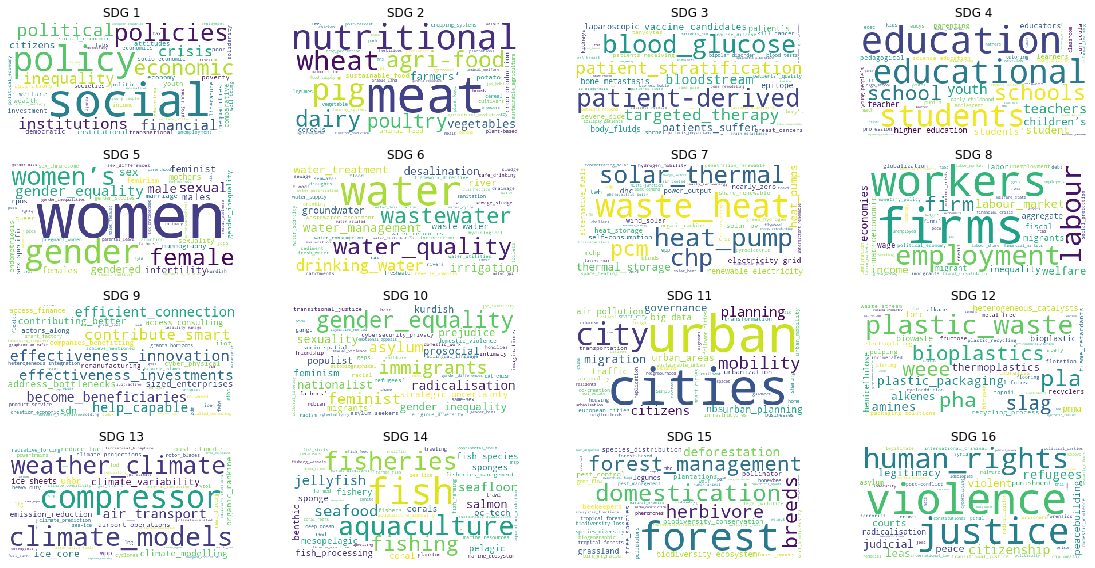

In [267]:
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(16,8))

col=0
row=0

for n,x in enumerate(sdg_sal):
    
    if col > 3:
        row+=1
        col=0
        
    make_wc(sdg_sal[n],ax[row][col],str(n+1))
    col+=1    
    
plt.tight_layout()   
#plt.subplots_adjust(hspace=0,wspace=0.1)

plt.savefig('../../figures/word_cloud.pdf')

In [292]:
# for n,sdg in enumerate(list(sdg_name_lookup.values())):
    
#     print(sdg)
    
#     titles = proj_sdg.sort_values(f'{str(n+1)}_prob',ascending=False)['title'][:2]
    
#     for t in titles:
#         print(f'\t {t[:200]}')
        
#     #print('\n')
    

### Simple descriptive analysis

In [411]:
proj_sdg['ecMaxContribution'] = [np.float(x.split(',')[0]) for x in proj_sdg['ecMaxContribution']]

In [370]:
sdg_thresh_cols = [x for x in proj_sdg.columns if 'thresh' in x]

In [375]:
proj_sdg[sdg_thresh_cols].sum(axis=1).mean()

0.7116359589464573

In [403]:
proj_sdg[sdg_thresh_cols].sum(axis=1).value_counts(normalize=True)

1    0.472816
0    0.413173
2    0.103747
3    0.009728
4    0.000536
dtype: float64

In [414]:
proj_sdg.loc[proj_sdg[sdg_thresh_cols].sum(axis=1)>0]['ecMaxContribution'].sum()/1e9

26.30857005

In [293]:
proj_sdg.rename(columns={'coordinatorCountry':'coord_country'},inplace=True)

In [419]:
proj_sdg_long = proj_sdg[
    ['start_year','coord_country','ecMaxContribution']+[x for x in proj_sdg.columns if 'thresh' in x]].melt(
    id_vars=['start_year','coord_country','ecMaxContribution'],var_name='sdg')

proj_sdg_long['sdg'] = [x.split('_')[0] for x in proj_sdg_long['sdg']]

In [436]:
#Level of activity by SDG

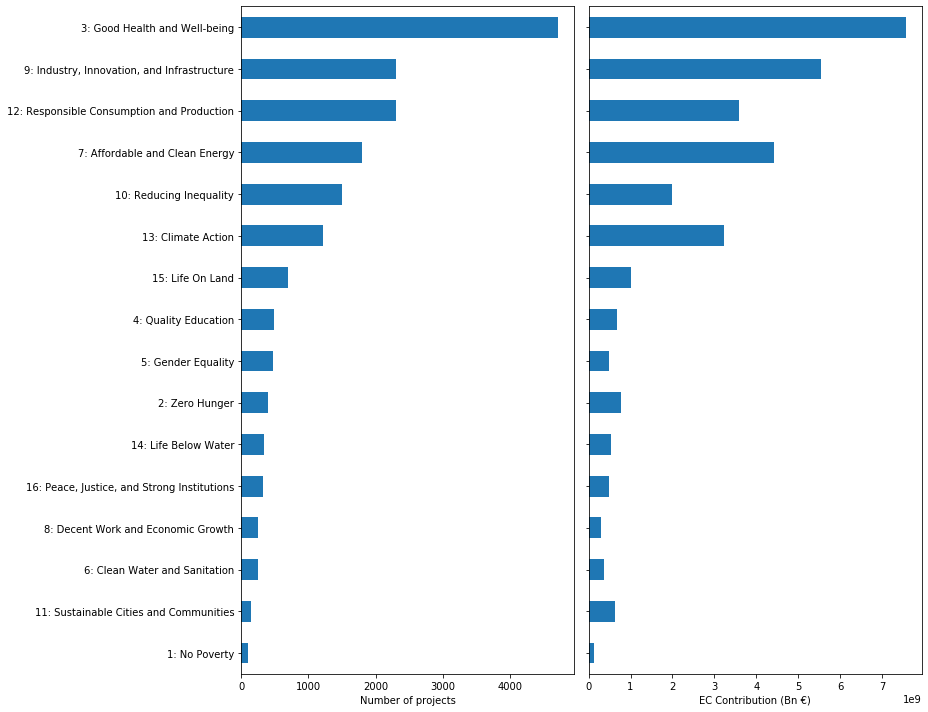

In [435]:
fig,ax = plt.subplots(ncols=2,figsize=(13,10),sharey=True)

projs = proj_sdg_long.groupby('sdg')['value'].sum().sort_values()

projs.plot.barh(ax=ax[0])


proj_sdg_long.loc[proj_sdg_long['value']>0].groupby('sdg')['ecMaxContribution'].sum().loc[projs.index].plot.barh(ax=ax[1])

ax[0].set_yticklabels([sdg_name_lookup[str(x.get_text())] for x in ax[0].get_yticklabels()])

ax[0].set_ylabel('')
ax[0].set_xlabel('Number of projects')
ax[1].set_xlabel('EC Contribution (Bn €)')

plt.tight_layout()

plt.savefig('../../figures/sdg_counts.pdf')

In [437]:
# Trends

In [383]:
proj_years_mean = proj_sdg_long.groupby(['sdg','start_year'])['value'].mean().reset_index(
    drop=False).pivot_table(index='start_year',columns='sdg',values='value')

In [381]:
sdg_sorted= projs_years.sum().sort_values().index

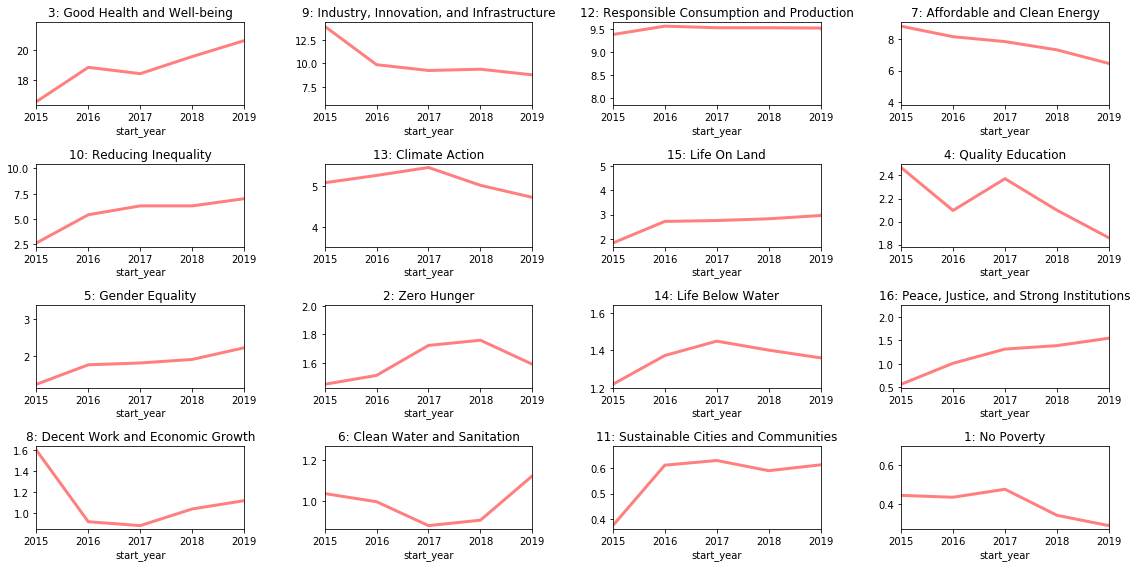

In [400]:
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(16,8))

col=0
row=0

for n,x in enumerate(sdg_sorted[::-1]):
    
    if col > 3:
        row+=1
        col=0
        
    (100*proj_years_mean[x].rolling(window=2).mean().dropna()).plot(ax=ax[row][col],color='red',alpha=0.5,
                                                                   linewidth=3)
    
    ax[row][col].set_xlim(2015,2019)
    
    ax[row][col].set_title(sdg_name_lookup[x][:50])
    
    col+=1    
    
plt.tight_layout()   


plt.savefig('../../figures/sdg_trends.pdf')

In [456]:
with open('../../data/eu_country_codes.txt','r') as infile:
    euro_codes = [x.split('-')[0].strip() for x in infile.read().split('\n')]

In [533]:
sdg_country = proj_sdg_long.groupby(['sdg','coord_country'])['value'].sum().reset_index(
    drop=False).pivot_table(columns='sdg',index='coord_country',values='value').loc[euro_codes,sdg_sorted]

sdg_country_shares = sdg_country/sdg_country.sum()

german_sdgs = sdg_country_shares.loc['DE'].sort_values(ascending=False).index

In [509]:
all_shares = (100*proj_sdg['coord_country'].value_counts(normalize=True)).to_dict()

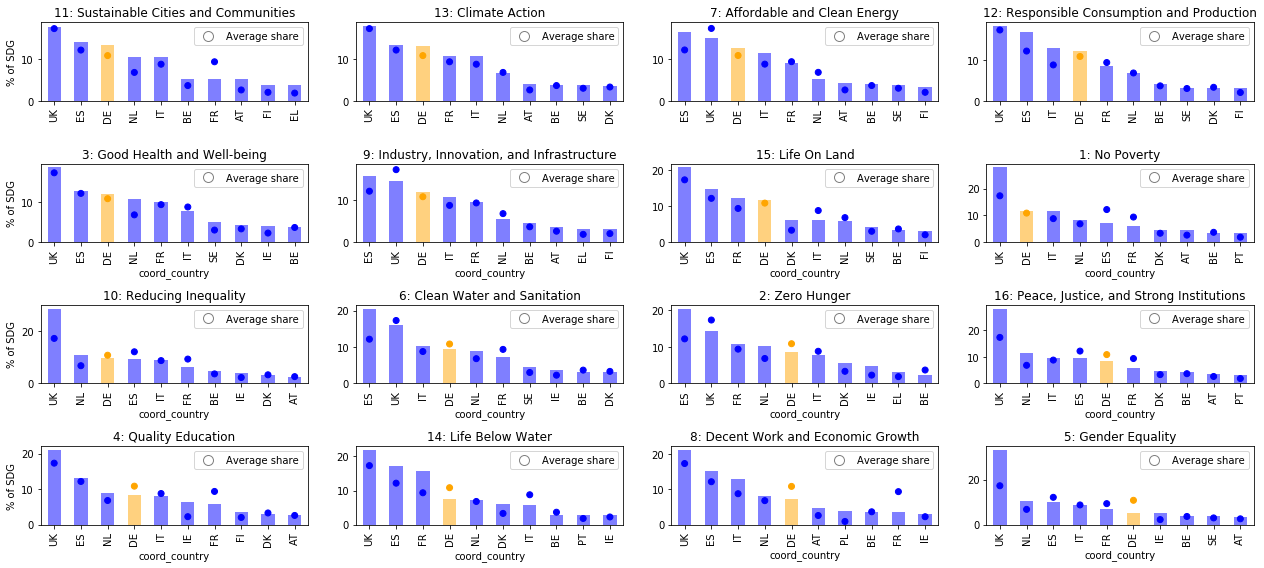

In [534]:
fig,ax = plt.subplots(nrows=4,ncols=4,figsize=(18,8))

col=0
row=0

leg_el = [Line2D([0],[0],color='white',marker='o',markersize=10,markerfacecolor='white',markeredgecolor='black',
                 label='Average share',
                alpha=0.5)]



for n,x in enumerate(german_sdgs):
    
    if col > 3:
        row+=1
        col=0
        
    
    sdg_act = 100*sdg_country_shares[x].sort_values(ascending=False)[:10]
    
    colors = ['blue' if x!='DE' else 'orange' for x in sdg_act.index]
    
    sdg_act.plot.bar(ax=ax[row][col],color=colors,alpha=0.5)
    
    ax[row][col].scatter(np.arange(0,len(sdg_act)),[all_shares[x] for x in sdg_act.index],
                        c=colors,edgecolor=colors,marker='o')
    
    ax[row][col].set_title(sdg_name_lookup[x][:50])
    ax[row][col].legend(handles=leg_el)
    
    if col==0:
        ax[row][col].set_ylabel('% of SDG')
        
    if row==0:
        ax[row][col].set_xlabel('')
    
    col+=1    
    
plt.tight_layout()   



plt.savefig('../../figures/sdg_countries.pdf')